In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


Initializing Libraries and Tools for Deep Learning

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


Dataset Compilation and DataFrame Generation.

In [3]:
#Read Data and Store it in a dataframe
# Generate data paths with labels
#Use your own dataset path in Google drive
data_dir = '/content/gdrive/MyDrive/Assignment/ST1/Capstone-Project/images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

Exploratory Data Analysis: Initial Data Overview.

In [4]:
#EDA Q1:How is the data distribution
df.head(5)

,filepaths,labels
0,/content/gdrive/MyDrive/Assignment/ST1/Capston...,cat
1,/content/gdrive/MyDrive/Assignment/ST1/Capston...,cat
2,/content/gdrive/MyDrive/Assignment/ST1/Capston...,cat
3,/content/gdrive/MyDrive/Assignment/ST1/Capston...,cat
4,/content/gdrive/MyDrive/Assignment/ST1/Capston...,cat


In [5]:
df.tail(5)

,filepaths,labels
642,/content/gdrive/MyDrive/Assignment/ST1/Capston...,loaf
643,/content/gdrive/MyDrive/Assignment/ST1/Capston...,loaf
644,/content/gdrive/MyDrive/Assignment/ST1/Capston...,loaf
645,/content/gdrive/MyDrive/Assignment/ST1/Capston...,loaf
646,/content/gdrive/MyDrive/Assignment/ST1/Capston...,loaf


Exploratory Data Analysis: Checking Label Availability.

In [6]:
#EDA Q2:Are there labels available for the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  647 non-null    object
 1   labels     647 non-null    object
dtypes: object(2)
memory usage: 10.2+ KB


Dataset Splitting for Training, Validation, and Testing.

In [7]:
#EDA 3: How much data can be used for training, validation and testing?
#Split dataframe into train, valid, and test
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

Visualizing and Preparing Image Data.

In [8]:
# EDA Q4: Can we visualise the data?
#Create image data generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 517 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


Visualization of Training Subset Samples.

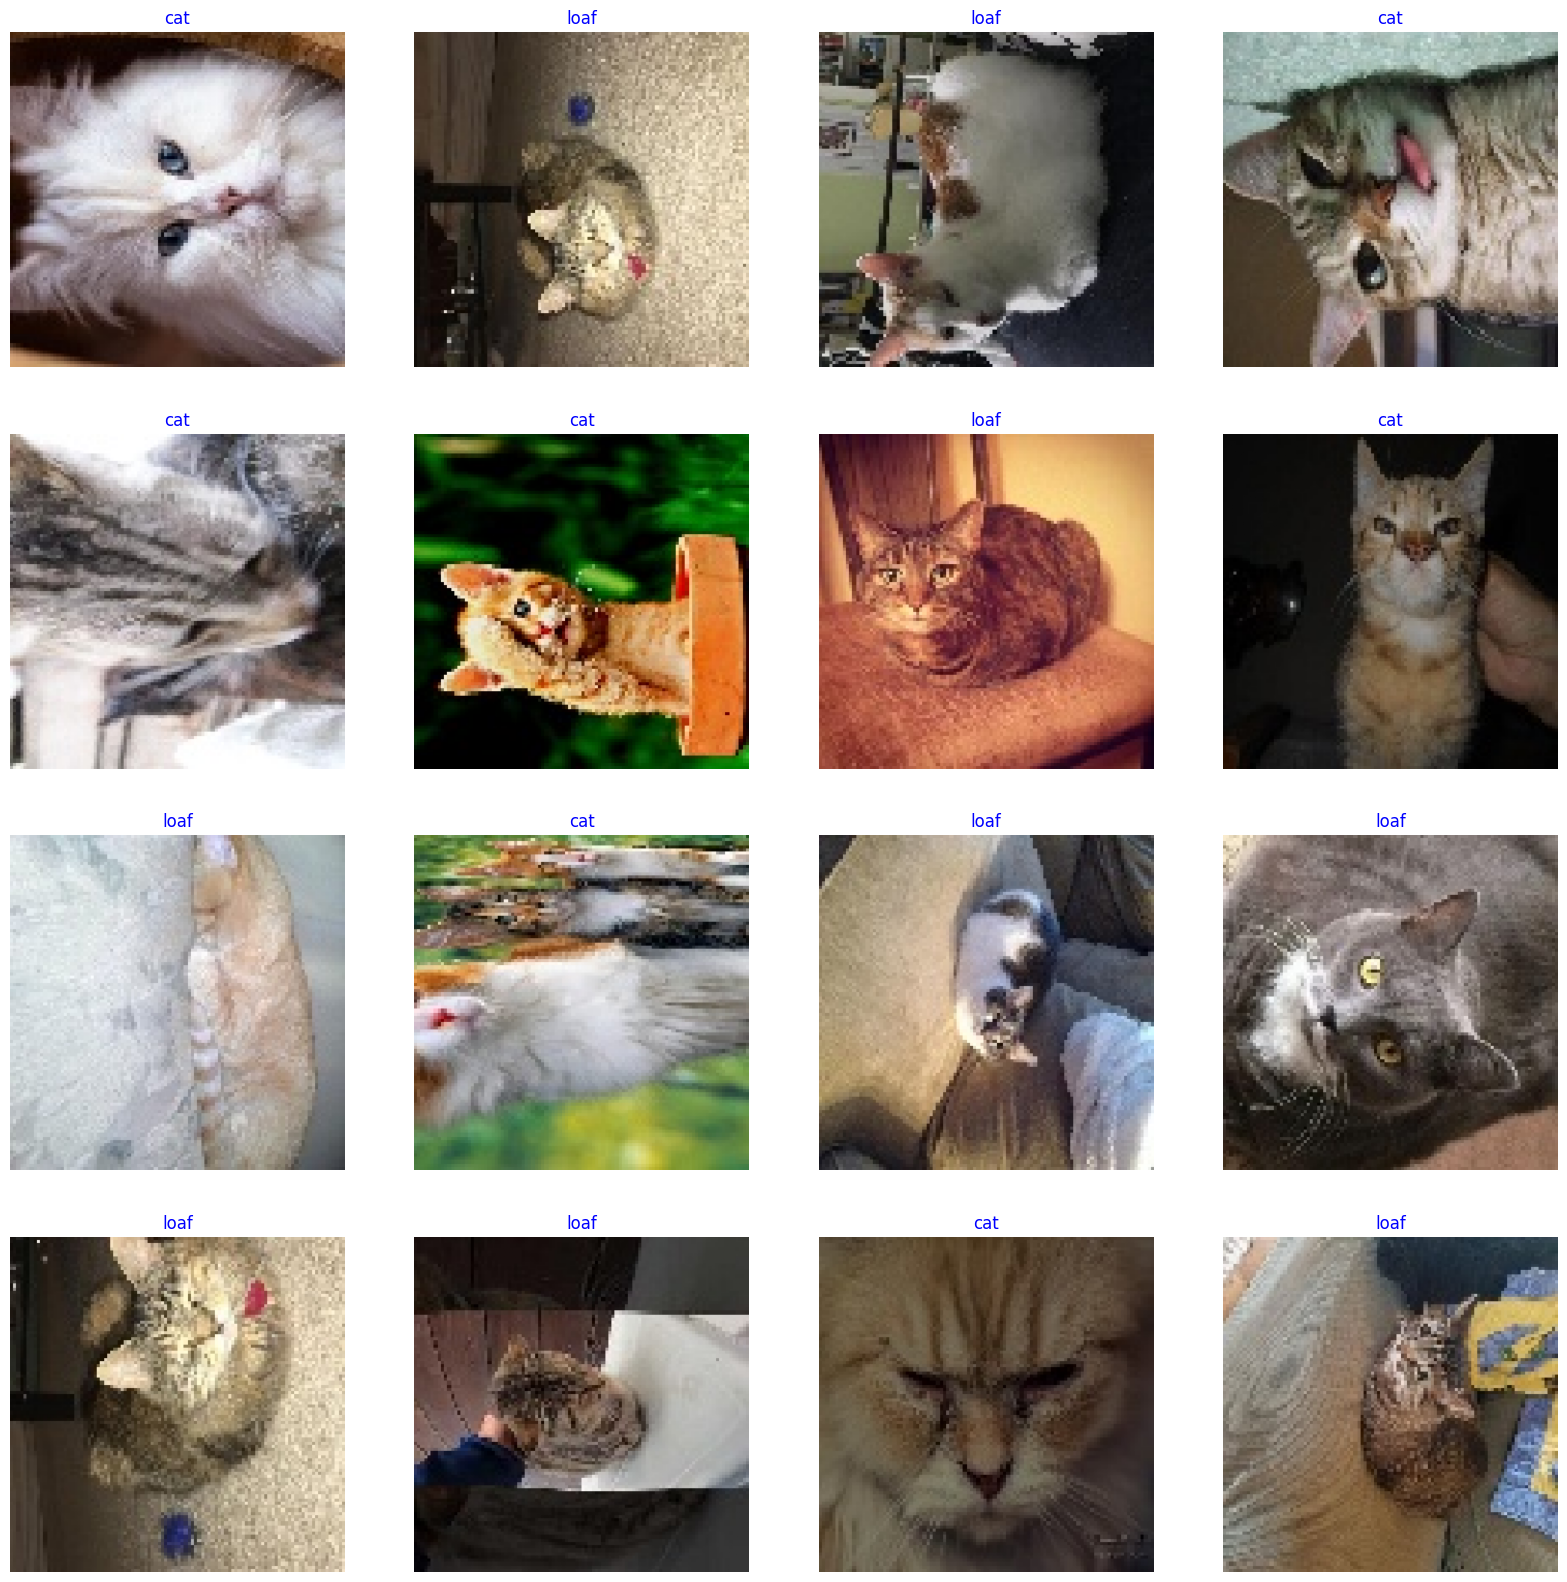

In [9]:
#EDA Q5: How does the samples from the training subset look like ?

g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Image Illumination and Camera Effects Analysis.

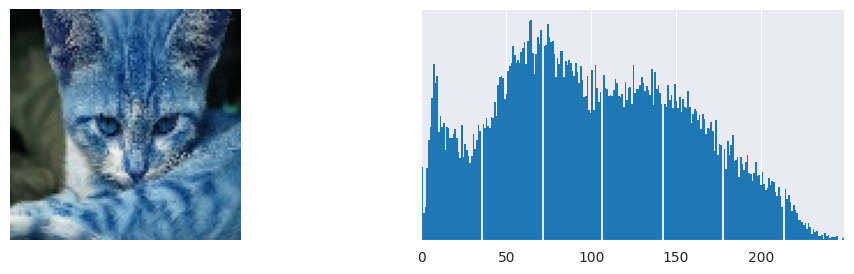

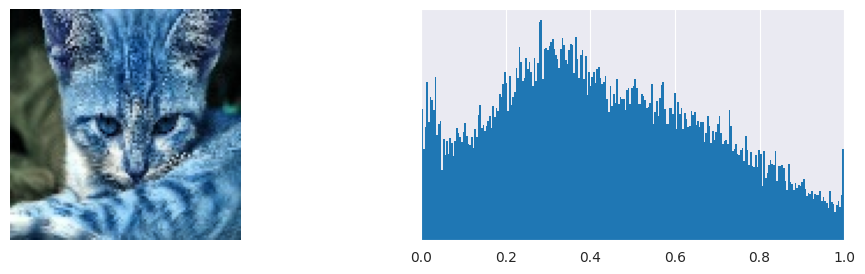

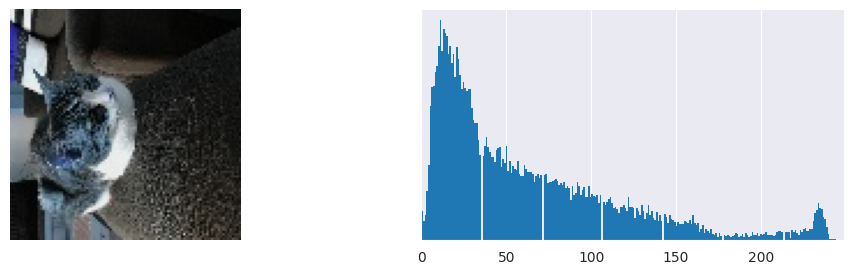

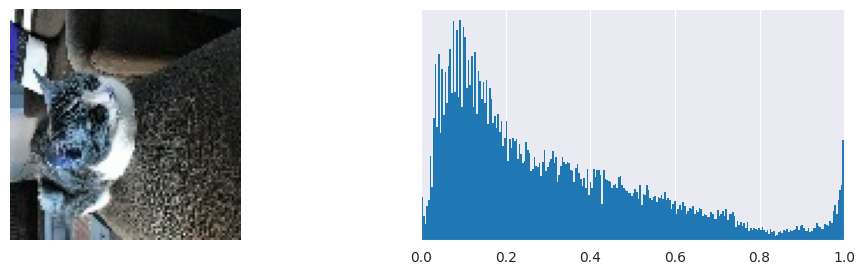

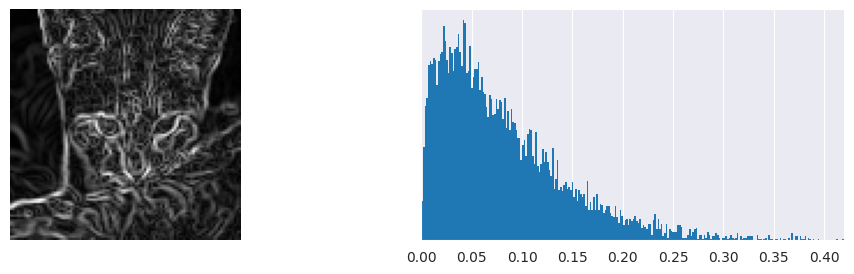

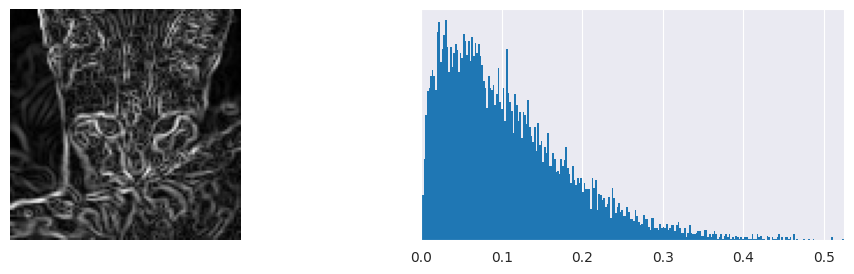

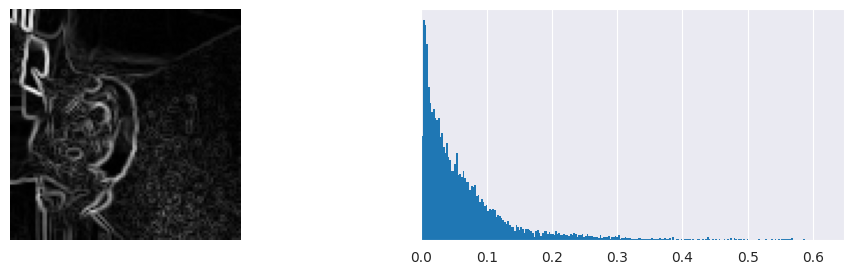

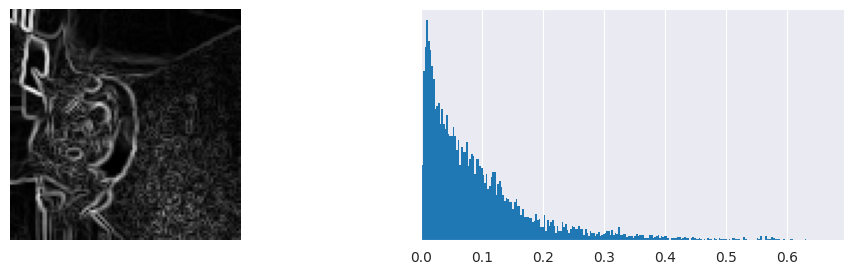

In [16]:
#Step 6 EDA: How discriminative are the images from different categories in terms of illumination and lighting artefacts
# i.e. what is the impact of camera effects/exposure of an image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
import skimage.exposure as skie
%matplotlib inline




img_path_1 = '/content/drive/MyDrive/Assignment/ST1/Capstone-Project/images/cat/cat_105.jpg'
img_1 = cv2.imread(img_path_1)
img_path_2 = '/content/drive/MyDrive/Assignment/ST1/Capstone-Project/images/loaf/loaf_cat_105.jpg'
img_2 = cv2.imread(img_path_2)

def show(img):
# Display the image.
  fig, (ax1, ax2) = plt.subplots(1, 2,
  figsize=(12, 3))
  ax1.imshow(img, cmap=plt.cm.gray)
  ax1.set_axis_off()

# Display the histogram.
  ax2.hist(img.ravel(), lw=0, bins=256)
  ax2.set_xlim(0, img.max())
  ax2.set_yticks([])
  plt.show()
show(img_1)
# adaptive histogram equalisation
show(skie.equalize_adapthist(img_1))

show(img_2)
# adaptive histogram equalisation
show(skie.equalize_adapthist(img_2))

#class 1 image
img = skic.rgb2gray(img_1)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_1))
sobimg_heq_1 = skif.sobel(img)
show(sobimg_heq_1)
#class 2 image
img = skic.rgb2gray(img_2)
sobimg_nheq= skif.sobel(img)
show(sobimg_nheq)
img = skic.rgb2gray(skie.equalize_adapthist(img_2))
sobimg_heq_2 = skif.sobel(img)
show(sobimg_heq_2)